In [55]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from matplotlib import pyplot as plt

In [56]:
spark = SparkSession.builder.getOrCreate()

In [57]:
df_train = spark.read.csv("BearTraining.csv", header=True, inferSchema=True)
df_train = df_train.select("Front Claws", "Pupillary Distance", "Ear Shape")
df_train = df_train.na.drop()

In [58]:
df_train = df_train.withColumn("Ear Shape", when(df_train["Ear Shape"]=="Pointed",0).
                               when(df_train["Ear Shape"]=="Broad",1).
                               when(df_train["Ear Shape"]=="Rounded",2))

In [59]:
cols = df_train.columns
df_train = VectorAssembler(inputCols = cols, outputCol = "Vector").transform(df_train)

In [60]:
scaler = StandardScaler(inputCol="Vector", outputCol="features")
df_train = scaler.fit(df_train).transform(df_train)

In [61]:
df_test = spark.read.csv("BearTesting.csv", header=True, inferSchema=True)
df_test = df_test.select("Front Claws", "Pupillary Distance", "Ear Shape", "Grizzly")
df_test = df_test.na.drop()

In [62]:
df_test = df_test.withColumn("Ear Shape", when(df_test["Ear Shape"]=="Pointed",0).
                               when(df_test["Ear Shape"]=="Broad",1).
                               when(df_test["Ear Shape"]=="Rounded",2))

df_test = df_test.withColumn("Grizzly", when(df_test["Grizzly"]=="Yes",1).otherwise(0))

In [63]:
cols = df_test.columns
cols.remove("Grizzly")
df_test = VectorAssembler(inputCols = cols, outputCol = "Vector").transform(df_test)

In [64]:
scaler = StandardScaler(inputCol="Vector", outputCol="features")
df_test = scaler.fit(df_test).transform(df_test)

In [65]:
kmeans = KMeans().setK(2).setSeed(1)
model = kmeans.fit(df_train)

In [66]:
predictions = model.transform(df_test)

In [67]:
predictions = predictions.toPandas()

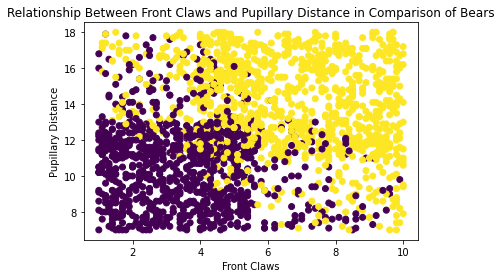

In [68]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Relationship Between Front Claws and Pupillary Distance in Comparison of Bears")
plt.scatter(predictions["Front Claws"], predictions["Pupillary Distance"], c=predictions["prediction"])
ax.set_xlabel("Front Claws")
ax.set_ylabel("Pupillary Distance")
plt.show()

In [69]:
count = 0
for index, row in predictions.iterrows():
    if row["Grizzly"]==row["prediction"]:
        count +=1

print("Accuracy: {}%".format(count / len(predictions) * 100))

Accuracy: 83.55%
